<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Named%20Entity%20Recognition%20with%20RoBERTa/Named_Entity_Recognition_with_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [2]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=695b738f51d87bb118c4500b28c7fbd4c11c06f08d0742d9c3d059cb91e6fb11
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import RobertaTokenizerFast, TFRobertaForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import create_optimizer
import evaluate

# **DATA PREPARATION**

In [5]:
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [7]:
dataset['train'][20 : 22]

{'id': ['20', '21'],
 'tokens': [['Rare',
   'Hendrix',
   'song',
   'draft',
   'sells',
   'for',
   'almost',
   '$',
   '17,000',
   '.'],
  ['LONDON', '1996-08-22']],
 'pos_tags': [[22, 22, 21, 21, 42, 15, 30, 3, 11, 7], [22, 11]],
 'chunk_tags': [[11, 12, 12, 12, 21, 13, 11, 12, 12, 0], [11, 12]],
 'ner_tags': [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [5, 0]]}

In [8]:
#ner_tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

#PER denoted token of class person
#ORG denotes token of class organization
#LOC denotes token of class location
#MISC denotes token of class miscellaneous
#O denotes a token that does not belong to any of the above 4 class categories

#B denotes token of a word of a particular class that occurs at the beginning of the word
#I denotes  token of a word of a particular class that occurs at the intermediate (includes end) (anything not at the beginning) of the word

#e.g. 'Hawkings' (a person) can be divided into tokens 'Hawk', '#in', '#gs' where 'Hawk' is B-PER, '#in' is I-PER and '#gs' is I-PER.

In [9]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id, add_prefix_space = True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
inputs = tokenizer(dataset["train"][20]["tokens"], is_split_into_words = True)
inputs.tokens()

['<s>',
 'ĠRare',
 'ĠHend',
 'rix',
 'Ġsong',
 'Ġdraft',
 'Ġsells',
 'Ġfor',
 'Ġalmost',
 'Ġ$',
 'Ġ17',
 ',',
 '000',
 'Ġ.',
 '</s>']

In [11]:
print(inputs.word_ids()) #word number that subword belongs to

[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 9, None]


In [12]:
print(dataset['train'][20]['ner_tags'])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


1 denotes 'Hendrix' is of class I-PER

In [13]:
'''Since tokenizer output does not match with ner_tags (which matched with original 'tokens' column in dataset)
due to subword tokenization splitting and adding space,
we change th ner_tags to suit the output of the tokenizer'''

def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word = None

  for word_id in word_ids:
    if word_id == None: #due to space <s> or padding
      new_labels.append(-100) #-100 is a special token that is ignored during computation
    elif word_id != current_word: #start of a new word
      current_word = word_id
      label = labels[word_id]
      new_labels.append(label)
    else: #token belongs to same word as previous token
      label = labels[word_id]

      #If this token belonged to B-XXX, we change its ner_tags to I-XXX due to it not being the beginning token now
      if label % 2 == 1: #checking if B-XXX
        label += 1 #converting it to corresponging I-XXX by adding 1
      new_labels.append(label)

  return new_labels

In [14]:
labels = dataset["train"][20]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[-100, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [15]:
def tokenizer_function(dataset):
  out = tokenizer(dataset["tokens"], truncation = True, is_split_into_words = True)
  out['labels'] = align_labels_with_tokens(dataset["ner_tags"], out.word_ids())
  return out

In [16]:
tokenized_dataset = dataset.map(tokenizer_function, remove_columns = ['id','tokens','pos_tags','chunk_tags','ner_tags',])

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [17]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [18]:
tokenized_dataset['train'][20]

{'input_ids': [0,
  28751,
  16544,
  15072,
  2214,
  2479,
  7683,
  13,
  818,
  68,
  601,
  6,
  151,
  479,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [19]:
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer, return_tensors = "tf")

In [20]:
batch_size = 16

In [21]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn = data_collator,
    shuffle = True,
    batch_size = batch_size,
)

In [22]:
tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn = data_collator,
    shuffle = False,
    batch_size = batch_size,
)

In [23]:
for i in tf_train_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[    0,   480, 15765, ...,     1,     1,     1],
       [    0,    22,   660, ...,     1,     1,     1],
       [    0,   152,    21, ...,     1,     1,     1],
       ...,
       [    0,  1811,   337, ...,     1,     1,     1],
       [    0,  5310,   377, ...,     1,     1,     1],
       [    0,  3015, 23088, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'labels': <tf.Tensor: shape=(16, 67), dtype=int64, numpy=
array([[-100,    0,    3, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -100],
       ...,
       [-100,    3,    4, ..., -100, -100, -100],
       [-100,    0,    0, ..., -100, -100, -

# **MODELING (TFRobertaForTokenClassification)**

In [24]:
model = TFRobertaForTokenClassification.from_pretrained(model_id, num_labels = 9)
model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 124061961 (473.26 MB)
Trainable params: 124061961 (473.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **TRAINING**

In [25]:
num_epochs = 6
batches_per_epoch = len(tokenized_dataset['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

In [26]:
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [27]:
model.compile(optimizer = optimizer)

In [29]:
history = model.fit(
    tf_train_dataset.take(120),
    validation_data = tf_val_dataset.take(25),
    epochs = num_epochs)

Epoch 1/6
120/120 [==============================] - 81s 342ms/step - loss: 0.5136 - val_loss: 0.1954
Epoch 2/6
120/120 [==============================] - 26s 217ms/step - loss: 0.1299 - val_loss: 0.1152
Epoch 3/6
120/120 [==============================] - 25s 211ms/step - loss: 0.1004 - val_loss: 0.0612
Epoch 4/6
120/120 [==============================] - 25s 205ms/step - loss: 0.0852 - val_loss: 0.0569
Epoch 5/6
120/120 [==============================] - 24s 200ms/step - loss: 0.0679 - val_loss: 0.0520
Epoch 6/6
120/120 [==============================] - 24s 201ms/step - loss: 0.0620 - val_loss: 0.0462


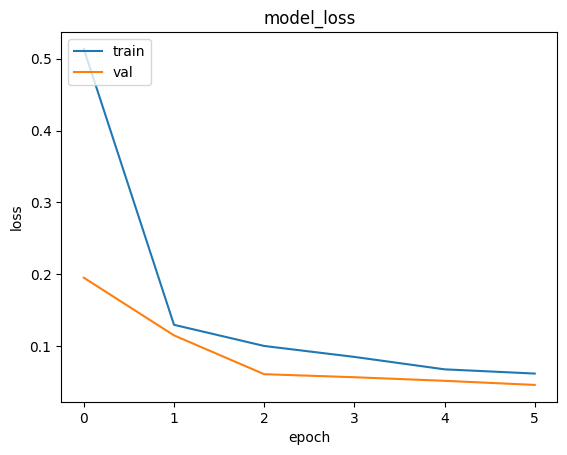

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# **EVALUATION**

In [31]:
metric = evaluate.load("seqeval")

In [32]:
ind_to_label = {0 : 'O', 1 : 'B-PER', 2 : 'I-PER', 3 : 'B-ORG', 4 : 'I-ORG', 5 : 'B-LOC', 6 : 'I-LOC', 7 : 'B-MISC', 8 : 'I-MISC'}
all_predictions = []
all_labels = []

In [33]:
for batch in tf_val_dataset.take(25):
  logits = model.predict(batch)["logits"]
  labels = batch["labels"].numpy()
  predictions = tf.argmax(logits, axis = -1).numpy()
  #print(labels)
  #print(predictions)
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):
      if label_idx == -100:
          continue
      all_predictions.append(ind_to_label[predicted_idx])
      all_labels.append(ind_to_label[label_idx])

1/1 [==============================] - 0s 86ms/step


In [34]:
print(all_predictions)
print(all_labels)

['O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 

In [35]:
metric.compute(predictions = [all_predictions], references = [all_labels])

{'LOC': {'precision': 0.9408602150537635,
  'recall': 0.9722222222222222,
  'f1': 0.9562841530054644,
  'number': 180},
 'MISC': {'precision': 0.8241758241758241,
  'recall': 0.8823529411764706,
  'f1': 0.8522727272727273,
  'number': 85},
 'ORG': {'precision': 0.9528795811518325,
  'recall': 0.9333333333333333,
  'f1': 0.9430051813471503,
  'number': 195},
 'PER': {'precision': 0.9595141700404858,
  'recall': 0.9713114754098361,
  'f1': 0.9653767820773931,
  'number': 244},
 'overall_precision': 0.9356643356643357,
 'overall_recall': 0.9502840909090909,
 'overall_f1': 0.9429175475687103,
 'overall_accuracy': 0.9862017804154303}

# **TESTING**

In [36]:
inputs = tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding = True, return_tensors = "tf")

In [37]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

['<s>', 'ĠWake', 'ĠUp', 'ĠJoe', 'Marsh', 'al', ',', 'Ġyou', 'Ġjust', 'Ġgot', 'Ġa', 'Ġcall', 'Ġfrom', 'ĠUNESCO', 'Ġfor', 'Ġa', 'Ġtrip', 'Ġto', 'ĠIndia', '</s>']
[None, 0, 1, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None]
tf.Tensor(
[[    0 11601  3105  2101 40825   337     6    47    95   300    10   486
     31 26688    13    10  1805     7   666     2]], shape=(1, 20), dtype=int32)


In [38]:
logits = model(**inputs).logits
print(logits.shape)
print(tf.argmax(logits, axis = -1))

(1, 20, 9)
tf.Tensor([[0 0 0 1 2 2 0 0 0 0 0 0 0 3 0 0 0 0 5 0]], shape=(1, 20), dtype=int64)


In [39]:
ind_to_label = {0 : 'O', 1 : 'B-PER', 2 : 'I-PER', 3 : 'B-ORG', 4 : 'I-ORG', 5 : 'B-LOC', 6 : 'I-LOC', 7 : 'B-MISC', 8 : 'I-MISC'}
out_str = ""
current_index = 0

In [40]:
for i in range(1, len(inputs.tokens())-1): #range(1, len(inputs.tokens())-1) to exclude None
  if tf.argmax(logits, axis = -1)[0][i] != 0:
    out_str += " " + str(inputs.tokens()[i]) + "--->" + str(ind_to_label[tf.argmax(logits, axis = -1).numpy()[0][i]])
  else:
    out_str += " " + str(inputs.tokens()[i])

In [41]:
print(out_str.replace("Ġ", ""))

 Wake Up Joe--->B-PER Marsh--->I-PER al--->I-PER , you just got a call from UNESCO--->B-ORG for a trip to India--->B-LOC
